In [1]:
from Bio import SeqIO
import pandas as pd
from glob import glob
import os
import matplotlib.gridspec as gridspec
import cv2 as cv
from glob import glob
import pandas as pd
from Bio import SeqIO
import os
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
import dendropy
from dendropy.calculate import treemeasure
import numpy as np
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats


fasta_sequences = SeqIO.parse(open('separated_alleles.faa'),'fasta')
seqs = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    seqs[name.replace('pGingerBS-_-_','')] = sequence

In [2]:
separated_df = pd.DataFrame([seqs]).T.reset_index()
separated_df['cluster'] = separated_df['index'].apply(lambda x: x.split('_')[0])
separated_df['cluster'] = separated_df['cluster'].replace({'virB1-11':'virB4'})
separated_df['allele'] = separated_df['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_-')[0])
separated_df['orf_number'] = separated_df['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_-_ORF_')[-1][0])
separated_df['allele'] = separated_df['allele'].map({'A4':'A4',
 'Ach5':'Ach5',
 'B21_90':'B21',
 'C58':'C58',
 'NCIB8196':'NCIB',
 'NCIB_8196':'NCIB',
 'Q15':'Q15',
 'S4':'S4',
 'T60_94':'T60',
 'pRi1724':'pRi',
 'pTiAB2':'TiAB',
 'pTiBo':'TiBo'})
separated_df = separated_df.drop(columns=['index']).rename(columns={0:'aa'})
separated_df

,aa,cluster,allele,orf_number
0,MLGASGTTERSGEVYLPYVGHVSDHIVLLEDGSIMTMAHVSGMAFE...,virB4,C58,1
1,MLGASGTTERSGEVYLPYVGHLSDHIVLLEDGSIMTMARLNGVAFE...,virB4,NCIB,1
2,MLGASGTTERSGEVYLPYVGHLTDHIVLLEDGSIMTMAHVSGMAFE...,virB4,A4,1
3,MLGASGTTERSGEIYLPYIGHLSDHIVLLEDGSIMSIARIDGVAFE...,virB4,Ach5,1
4,MLGASGTTERSGEIYLPYIGHLSDHIVLLEDGSIMTIARIDGVAFE...,virB4,TiBo,1
...,...,...,...,...
113,MPCAPVDDVTTIDDLTLDPYPIYRRMRVQNPVVHVASVRRTFLTKA...,virH2,TiBo,1
114,MQLAPVDGVTTIDDLTLDPYPIYRRMRAQTPVVRVASVKRTFLTKA...,virH2,NCIB,1
115,MQLAPVDRVTTIDDLTLDPYPIYRRMRAQTPVVRVASVMRTFLTKA...,virH2,C58,1
116,MEERRVSISSITWRFPMLFAPVDDVTTIDDLTLDPYPIYRRMRVQN...,virH2,Ach5,1


In [3]:
merged_df = pd.DataFrame(columns=separated_df.columns)
for cluster in ['virE12','virD12','virC12']:
    cluster_query = separated_df.query(f'cluster == "{cluster}"')
    cluster_list = []
    for allele in cluster_query['allele'].unique():
        cluster_allele_query = cluster_query.query(f'allele == "{allele}"')
        sorted_list = sorted(zip(cluster_allele_query['orf_number'], cluster_allele_query['aa']))
        assert len(sorted_list) == 2
        concatenated_seq = ''.join([seq[1] for seq in sorted_list])
        cluster_list.append([
            concatenated_seq,cluster,allele,1
        ])
    merged_df = pd.concat([merged_df, pd.DataFrame(cluster_list,columns=separated_df.columns)])
df = pd.concat([
    separated_df[~separated_df['cluster'].isin(['virE12','virD12','virC12'])], 
    merged_df
]).reset_index(drop=True).drop(columns=['orf_number'])
df

,aa,cluster,allele
0,MLGASGTTERSGEVYLPYVGHVSDHIVLLEDGSIMTMAHVSGMAFE...,virB4,C58
1,MLGASGTTERSGEVYLPYVGHLSDHIVLLEDGSIMTMARLNGVAFE...,virB4,NCIB
2,MLGASGTTERSGEVYLPYVGHLTDHIVLLEDGSIMTMAHVSGMAFE...,virB4,A4
3,MLGASGTTERSGEIYLPYIGHLSDHIVLLEDGSIMSIARIDGVAFE...,virB4,Ach5
4,MLGASGTTERSGEIYLPYIGHLSDHIVLLEDGSIMTIARIDGVAFE...,virB4,TiBo
...,...,...,...
82,MKLLTFCSFKGGAGKTTALMGLCTAFARDGKRVALFDADENRPLTR...,virC12,TiAB
83,MQLLTFCSFKGGAGKTTALMGLCAALANDGKRVALFDADENRPLTR...,virC12,TiBo
84,MKLLAFCSFKGGAGKTTALMGLCTAFARDGKRVALLDADENRPLTR...,virC12,S4
85,MKLLTFCSFKGGAGKTTALMGLCAAFANSGRRVALLDADENRPLRR...,virC12,T60


In [4]:
for cluster in df['cluster'].unique():
    with open(f'{cluster}_alleles.faa','w') as f:
        for _,row in df.query(f'cluster == "{cluster}"').iterrows():
            f.write(f'>{row["cluster"]}_{row["allele"]}\n{row["aa"]}\n')
    
with open(f'all_alleles.faa','w') as f:
    for _,row in df.iterrows():
        f.write(f'>{row["cluster"]}_{row["allele"]}\n{row["aa"]}\n')


In [5]:
for cluster in glob('./vir*.faa'):
    outfile = cluster.split('/')[-1].replace('.faa','')
    os.system(f'mafft --quiet {outfile}.faa > output/{outfile}.aln')
    os.system(f'FastTree -quiet output/{outfile}.aln > output/{outfile}.tree')

In [6]:
dist_df = pd.DataFrame(columns=['tax1','tax2','dist','cluster','allele'])
for tree_file in glob("output/*.tree"):
    handle = tree_file.split('/')[-1].replace('.tree','')
    dists=[]
    tree = dendropy.Tree.get_from_path(tree_file, "newick")
    for x in tree.taxon_namespace:
        if 'C58' in x.label:
            for y in tree.taxon_namespace:
                dists.append([x.label,y.label,
                            treemeasure.patristic_distance(tree,x,y)])
    tmp_df = pd.DataFrame(dists,columns=['tax1','tax2','dist'])
    tmp_df['cluster'] = handle.replace('_alleles','')
    dist_df = pd.concat([dist_df,tmp_df]).reset_index(drop=True)
    del tmp_df
dist_df['allele'] = dist_df['tax2'].apply(lambda x: x.split(' ')[-1])
dist_df.groupby(['cluster']).count()

,tax1,tax2,dist,allele
cluster,,,,
virB4,8,8,8,8
virC12,11,11,11,11
virD12,11,11,11,11
virD4,10,10,10,10
virD5,10,10,10,10
virE12,9,9,9,9
virE3,10,10,10,10
virF,5,5,5,5
virH1,8,8,8,8


In [7]:
data_df = pd.read_pickle('../02-refactor_data/refactor_data/fig3_plant_data.pkl')
data_df['vir'] = data_df['vir'].replace({'virB':'virB4','virC':'virC12'})
data_df.groupby(['vir'])['Strain'].nunique()

vir
virB4     11
virC12    13
virD12    14
virD4     12
virD5     11
virE12    11
virE3     11
virF       6
virH1     10
virH2      9
Name: Strain, dtype: int64

In [8]:
merged_df = data_df.merge(dist_df,left_on=['vir','Strain'],right_on=['cluster','allele']).drop(columns=['Strain','vir','Leaf','Plant','Well'])
# merged_df = merged_df.groupby(['cluster','allele']).mean().reset_index()
merged_df['GFP_log'] = merged_df.GFP.apply(np.log2)

In [9]:
data_df.query('vir == "virB4"')['Strain'].unique()

array(['WT', 'ΔvirB1-11', 'A4', 'Ach5', 'C58', 'NCIB', 'Q15', 'TiAB',
       'TiBo', 'T60', 'Leaf'], dtype=object)

In [10]:
merged_df.to_csv('df_dist_compare_fixed.csv')

/home/lucas/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


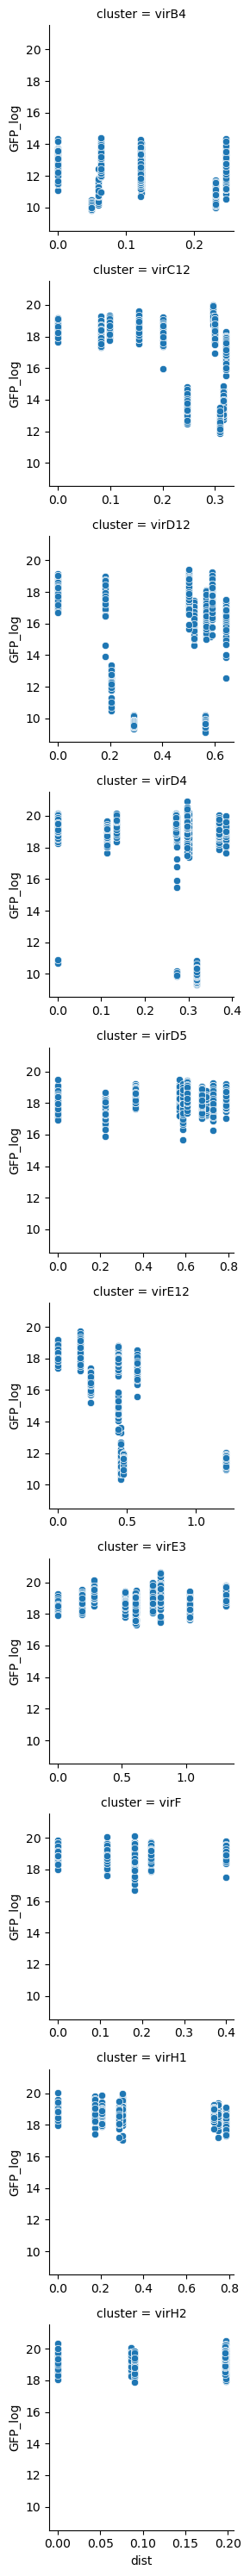

In [11]:
g = sns.FacetGrid(merged_df, row="cluster",sharex=False)
g.map(sns.scatterplot, "dist", "GFP_log")
plt.show()

In [12]:
fig = plt.figure(figsize = (8,14))
gs = gridspec.GridSpec(5,2,hspace=0.6)

clusters = sorted(df_dist_compare['cluster'].unique())
for i, g in enumerate(gs):
    ax = fig.add_subplot(g)
    query = df_dist_compare.query(f'cluster == "{clusters[i]}"')
    duplicated = query[query['match'].duplicated()]
    g = sns.scatterplot(data=query,x='dist',y='Mean',linewidth=1,edgecolor='black',color='lightskyblue',ax=ax,s=50)
    g = sns.scatterplot(data=duplicated,x='dist',y='Mean',linewidth=1,edgecolor='black',color='red',ax=ax,s=50)
    pearson = scipy.stats.pearsonr(query.dist,query.Mean)
    spearman = scipy.stats.spearmanr(query.dist,query.Mean)
    g.set(xlabel=None,ylabel=None,title=f'${clusters[i]}$\n(pearson = {pearson.pvalue:.2f}, spearman = {spearman.pvalue:.2f})')
    ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
    sns.despine()
    if i in [8,9]:
        g.set(xlabel='Distance from C58')
    if i % 2 == 0:
        g.set(ylabel='Mean GFP')

fig.savefig('tmp.png',dpi=600,facecolor='white',bbox_inches='tight')

NameError: name 'df_dist_compare' is not defined